In [1]:
# Python 3.10.14
# Below works only on Python > 3.9 
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --upgrade --force-reinstall
# pip show torh # 2.5.1+cu121
# pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# pip install pandas matplotlib pillow tqdm 
# pip install gdown

In [2]:
if False: 
    !gdown https://drive.google.com/uc?id=1nlc9-jm9eFIwLyMHdPqmxauB-fHyrkTn

    import shutil
    shutil.unpack_archive('data.zip') 

In [2]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

from unsloth import FastVisionModel
import torch

from collections import Counter
pd.options.display.max_rows = 5

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


# Data pre-processing

Assumptions:
- Train, test data only for now, no val data used

In [2]:
# Images

path_images = Path("data/images")
ids_images = [folder.name for folder in path_images.iterdir() if folder.is_dir()]

len(ids_images), ids_images[:3]

(2955, ['CXR1000_IM-0003', 'CXR1001_IM-0004', 'CXR1004_IM-0005'])

In [3]:
# Annotations

path_annot = 'data/annotation_quiz_all.json'
with open(path_annot, 'r') as f:
    data = json.load(f)

filtered_data = {k: v for k, v in data.items() if k in ['test', 'train']}

df_train = pd.DataFrame(filtered_data['train'])
df_test  = pd.DataFrame(filtered_data['test'])
df_data  = pd.concat([df_train, df_test], ignore_index=True)

assert len(set(df_data.id)) == len(df_data.id)

df_data = df_data.set_index('id')
df_data

,report,split
id,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train
...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test


In [4]:
ids_annot = df_data.index.to_list()
assert all(item in ids_images for item in ids_annot)

len(ids_annot), ids_annot[:3]

(2659, ['CXR2384_IM-0942', 'CXR2926_IM-1328', 'CXR1451_IM-0291'])

In [5]:
# Vast majority of images consists of 2 images. Let's assume we select only the first 2. Ideally, need to generalize this later.

def count_images_in_folder(folder_path):

    count = sum(1 for file in folder_path.iterdir() if file.suffix.lower() in {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"} )
    return count

images_count = {folder_id: count_images_in_folder(path_images / folder_id) for folder_id in ids_annot}

Counter(images_count.values())

Counter({2: 2519, 3: 136, 4: 4})

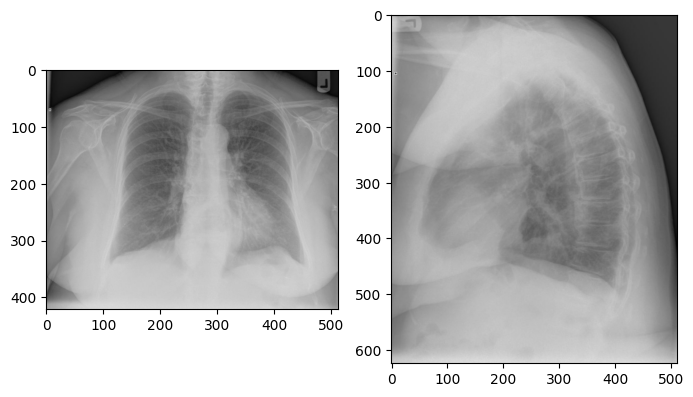

In [6]:
# Plot manually selected id. Images are various sizes.

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
for ax, image_filename in zip(axes, ["0.png", "1.png"]):
    path_image = path_images / ids_annot[0] / image_filename
    img = Image.open(path_image)
    ax.imshow(img)

plt.tight_layout()

In [7]:
sizes = []

for folder_id in tqdm(ids_annot):
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")

        sizes.append({'id': folder_id,
                      'img0_w': img0.size[0], 'img0_h': img0.size[1],
                      'img1_w': img1.size[0], 'img1_h': img1.size[1] })
    except FileNotFoundError as e:
        print(f"File not found: {e}")

sizes = pd.DataFrame(sizes).set_index('id')
sizes

  0%|          | 0/2659 [00:00<?, ?it/s]

,img0_w,img0_h,img1_w,img1_h
id,,,,
CXR2384_IM-0942,512,420,512,624
CXR2926_IM-1328,512,512,512,562
...,...,...,...,...
CXR2312_IM-0887,512,624,512,624
CXR49_IM-2110,512,420,512,624


In [8]:
# Widths of images 0 and 1 are the same 512. Can concatinate based on the same widths for training/testing

sizes['img0_w'].value_counts(dropna=False), sizes['img1_w'].value_counts(dropna=False)

(img0_w
 512    2659
 Name: count, dtype: int64,
 img1_w
 512    2659
 Name: count, dtype: int64)

In [9]:
def concatenate_images_vertically(image1, image2, shared_width=512):

    assert shared_width == image1.width == image2.width

    total_height = image1.height + image2.height
    concatenated_image = Image.new('RGB', (shared_width, total_height))
    concatenated_image.paste(image1.crop((0, 0, shared_width, image1.height)), (0, 0))
    concatenated_image.paste(image2.crop((0, 0, shared_width, image2.height)), (0, image1.height))
    return concatenated_image

df_data['image'] = None
for folder_id in tqdm(ids_annot):
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")
        concatenated_image = concatenate_images_vertically(img0, img1)

        df_data.loc[folder_id , 'image'] = concatenated_image

    except FileNotFoundError as e:
        print(f"File not found: {e}")

df_data

  0%|          | 0/2659 [00:00<?, ?it/s]

,report,split,image
id,,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train,<PIL.Image.Image image mode=RGB size=512x1044 ...
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train,<PIL.Image.Image image mode=RGB size=512x1074 ...
...,...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test,<PIL.Image.Image image mode=RGB size=512x1044 ...


In [74]:
data_test  = df_data.loc[df_data['split'] == 'test',  :].copy()
data_test

,report,split,image
id,,,
CXR3030_IM-1405,"{'bone': 'No acute bony abnormality.', 'heart'...",test,<PIL.Image.Image image mode=RGB size=512x1044 ...
CXR38_IM-1911,"{'bone': 'Bony structures are intact.', 'heart...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
...,...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test,<PIL.Image.Image image mode=RGB size=512x1044 ...


# Inference on Test Data

In [16]:
from transformers import TextStreamer

model_name = "Aidan777/Llama-3.2-11B-Vision-Instruct_finetuned_xray_report"

model, tokenizer = FastVisionModel.from_pretrained(
                                        model_name=model_name, 
                                        load_in_4bit=True)

==((====))==  Unsloth 2025.1.7: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.536 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.6. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

In [ ]:
instruction_user = """
You are a specialist Radiologist specializing in the analysis of chest X-ray images by looking at them.
Your goal is to analyze X-ray images and write diagnostic reports based on X-ray images.
You only write reports for five anatomical regions: lung, heart, mediastinal, bone, and others.
Each report may not necessarily include findings for all regions. Some regions might be empty.
You are provided with a chest X-ray image.
Write a radiology report accurately by looking at the image provided.
Each image is the Frontal and Lateral X-ray images concatenated vertically, with no particular order.
Write the report carefully. Consider each anatomical region separately, but you don't have to write a report for each region.
"""

In [ ]:
FastVisionModel.for_inference(model)

outputs = {}
for i in tqdm(range(len(data_test))):

    image = data_test.iloc[i]['image']
    idx   = data_test.index[i]
    assert isinstance(image, Image.Image)  
    
    messages = [{"role": "user",
                 "content": [{"type": "image"},
                             {"type": "text", "text": instruction_user}]}]

    input_text    = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs        = tokenizer(image, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    
    output = model.generate(**inputs,
                            streamer=text_streamer,
                            max_new_tokens=128, # of the output
                            use_cache=True,
                            temperature=1.5,
                            min_p=0.1)

    token_ids = output[0]
    decoded_text = tokenizer.decode(token_ids, skip_special_tokens=True)
    start_index = decoded_text.find("\nassistant\n\n")
    required_text = decoded_text[start_index+len("\nassistant\n\n"):] if start_index != -1 else ""
    print('--------------------', 'len(required_text):', len(required_text))
    del output
    
    outputs[idx] = required_text

In [4]:
file_name = "Llama-3.2-11B-Vision-Instruct_finetuned_xray_report_TEST_OUTPUT.json"

if False: 
    with open(file_name, "w") as file:
        json.dump(outputs, file, indent=4)        

590

# Model Performance Evaluation

GREEN: Generative Radiology Report Evaluation and Error Notation. https://github.com/Stanford-AIMI/GREEN/tree/main

To install in Jupyter Labs, first, in terminal:
- make sure you have python >= 3.121 or install it
- python3.12 -m venv myenv3124     # create venv 
- source myenv3124/bin/activate    
- pip install ipykernel
- python3.12 -m ipykernel install --user --name=myenv3124 --display-name "myenv3124"
	

To install GREEN, first: 
- Python 3.12.1 (works on 3.12.4)
- pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu118

Then follow - https://github.com/Stanford-AIMI/GREEN/tree/main : 
- git clone https://github.com/Stanford-AIMI/GREEN.git
- cd GREEN
- pip install -e .

In [1]:
import sys
print(sys.executable)

/home/myenv3124/bin/python3.12


In [2]:
from huggingface_hub import notebook_login
notebook_login() 

In [12]:
from green_score import GREEN

refs = [
    "Interstitial opacities without changes.",
    "Interval development of segmental heterogeneous airspace opacities throughout the lungs . No significant pneumothorax or pleural effusion . Bilateral calcified pleural plaques are scattered throughout the lungs . The heart is not significantly enlarged .",
    "Lung volumes are low, causing bronchovascular crowding. The cardiomediastinal silhouette is unremarkable. No focal consolidation, pleural effusion, or pneumothorax detected. Within the limitations of chest radiography, osseous structures are unremarkable.",
]
hyps = [
    "Interstitial opacities at bases without changes.",
    "Interval development of segmental heterogeneous airspace opacities throughout the lungs . No significant pneumothorax or pleural effusion . Bilateral calcified pleural plaques are scattered throughout the lungs . The heart is not significantly enlarged .",
    "Endotracheal and nasogastric tubes have been removed. Changes of median sternotomy, with continued leftward displacement of the fourth inferiomost sternal wire. There is continued moderate-to-severe enlargement of the cardiac silhouette. Pulmonary aeration is slightly improved, with residual left lower lobe atelectasis. Stable central venous congestion and interstitial pulmonary edema. Small bilateral pleural effusions are unchanged.",
]

model_name = "StanfordAIMI/GREEN-RadLlama2-7b"

green_scorer = GREEN(model_name, output_dir=".")
mean, std, green_score_list, summary, result_df = green_scorer(refs, hyps)
print(green_score_list)
print(summary)
for index, row in result_df.iterrows():
    print(f"Row {index}:\n")
    for col_name in result_df.columns:
        print(f"{col_name}: {row[col_name]}\n")
    print('-' * 80)

/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Processing data...making prompts


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:22, 22.13s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  9.653854608535767
[1.0, 1.0, 0]

-------------GREEN-RadLlama2-7b----------------
 [Summary]: Green average 0.6666666666666666 and standard deviation 0.4714045207910317 
 [Clinically Significant Errors Analyses]: <accuracy>. <representative error>

(a) False report of a finding in the candidate: 0.6666666666666666. 
  Changes of median sternotomy 

(b) Missing a finding present in the reference: 0.6666666666666666. 
  No focal consolidation, pleural effusion, or pneumothorax. 

(c) Misidentification of a finding's anatomic location/position: 1.0. 
 None 

(d) Misassessment of the severity of a finding: 1.0. 
 None 

(e) Mentioning a comparison that isn't in the reference: 1.0. 
 None 

(f) Omitting a comparison detailing a change from a prior study: 1.0. 
 None 

----------------------------------

Row 0:

reference: Interstitial opacities without changes.

predictions: Interstitial opacities at bases without changes.

green_analysis: 
The candidate report specifie

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
from green_score import GREEN

model_name = "Aidan777/Llama-3.2-11B-Vision-Instruct_finetuned_xray_report"
green_scorer = GREEN(model_name, output_dir=".")

In [ ]:
with open(file_name, "r") as file:
    outputs = json.load(file)    
len(outputs)    